# 03 - Scraping Audio Data from Spotify
Spotify maintains a set of audio features for each song, including metrics like loudness, energy, valence, instrumentalness, danceability, etc. These features can be obtained through querying Spotify's API.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import spotipy
import spotipy.util
import os
import pickle as pkl
import re

from importlib import reload
from matplotlib import rcParams

rcParams['font.family'] = 'serif'
rcParams['font.serif'] = 'times new roman'

% matplotlib inline
%config InlineBackend.figure_format = 'retina'

pd.options.display.max_columns = 999
warnings.filterwarnings('ignore')

## Authorization

In [3]:
def get_auth_token(username, client_id, client_secret, redirect_uri):
    try:
        os.remove(f".cache-{username}")
    except:
        None
        
    token = spotipy.util.prompt_for_user_token(
        username, client_id=client_id, client_secret=client_secret,
        redirect_uri=redirect_uri)

    return token

In [4]:
# define data directory where credentials and data (old and new) are stored
data_dir = os.path.join('..','data')
with open(os.path.join(data_dir, 'credentials.dict'), 'rb') as f:
    credentials = pkl.load(f)

token = get_auth_token(**credentials)



            User authentication requires interaction with your
            web browser. Once you enter your credentials and
            give authorization, you will be redirected to
            a url.  Paste that url you were directed to to
            complete the authorization.

        
Opened https://accounts.spotify.com/authorize?client_id=64b18eca4ca84ba6805e68c9a3cdbf7d&response_type=code&redirect_uri=http%3A%2F%2Flocalhost%3A8888%2F in your browser


Enter the URL you were redirected to: http://localhost:8888/tree?code=AQC_QeGWT5J1etHjDd67uTx0N1EuEv7AHNmkGOJKmGBcxRHE9r9fx5KroC7cjHUrHmD31YFLOss3J0AfNmbUv_rY3nDkkN3jHN2edNrObYCwPiXR1cECNeF-F_JsmMu9GkUZcOKWbcfr7msTWiiNaIvzh9OAs0XqlWBKW1QuZ3Gol3kYJJsPaleWu6Q




## Query Spotify

In [6]:
def query_spotify(songs_df, token, verbose=False):
    """
    Function queries the spotifyAPI, by using the artist name and the song title
    :param filepath: str | filepath
    :return: pd.DataFrame | dataframe with the audio features from the spotifyAPI
    """
    # search for track + name
    audio_features_df = pd.DataFrame()
    
    failed = []
    for index, row in songs_df.iterrows():
        name = row['song_clean']
        artist = row['artist_clean']
        year = row['year']
        try:
            spotify = spotipy.Spotify(auth=token)
            results = spotify.search(
                q='track:' + name + ' artist:' + artist, type='track',
                limit=1)
            uri = results['tracks']['items'][0]['uri']
            spotify_song = results['tracks']['items'][0]['name']
            album_name = results['tracks']['items'][0]['album']['name']
            sp_artist = results['tracks']['items'][0]['artists'][0]['name']
            popularity = results['tracks']['items'][0]['popularity']
            release_date = results['tracks']['items'][0]['album']['release_date']
            explicit = results['tracks']['items'][0]['explicit']
            
            if verbose:
                print('successfully queried song {}: {} by {}'.format(index, name, artist))

            audio_feat = spotify.audio_features(uri)
            x = audio_feat[0]
            x.pop('analysis_url')
            x.pop('track_href')
            x['spotify_song'] = spotify_song
            x['spotify_album'] = album_name
            x['spotify_artist'] = sp_artist
            x['billboard_name'] = name
            x['billboard_artist'] = artist
            x['popularity'] = popularity
            x['release_date'] = release_date
            x['explicit'] = explicit
            x['billboard_df_index'] = index
            
            audio_features_df = audio_features_df.append(x, ignore_index=True)
        except:
            if verbose:
                print('failed song {}: {} by {}'.format(index, name, artist, year))
            failed.append([name, artist, year])
            None
            
    failed = pd.DataFrame(failed, columns=['song', 'artist', 'year'])
    return audio_features_df, failed

In [15]:
billboard = pd.read_csv('../data/billboard-lyrics.csv')
billboard.sample(3)

,index,artist_all,artist_base,rank,song,year,artist_featured,song_clean,artist_clean,lyrics,source
5353,52,pink,pink,53,try,2013,NaN,try,pink,\n Ever wonder about what hes doing \nHow it...,genius.com
888,88,simon & garfunkel,simon and garfunkel,89,scarborough fair,1968,NaN,scarborough fair,simon and garfunkel,Simon And Garfunkel \nConcert In Central Park ...,songlyrics.com
1980,79,herb alpert,herb alpert,80,rise,1979,NaN,rise,herb alpert,Instrumental,genius.com


In [7]:
df2, failed = query_spotify(billboard, token, verbose=True)

successfully queried song 0: theme from a summer place by percy faith
successfully queried song 1: hell have to go by jim reeves
successfully queried song 2: cathys clown by the everly brothers
successfully queried song 3: running bear by johnny preston
successfully queried song 4: teen angel by mark dinning
successfully queried song 5: im sorry by brenda lee
successfully queried song 6: its now or never by elvis presley
successfully queried song 7: handy man by jimmy jones
successfully queried song 8: stuck on you by elvis presley
successfully queried song 9: the twist by chubby checker
successfully queried song 10: everybodys somebodys fool by connie francis
successfully queried song 11: wild one by bobby rydell
successfully queried song 12: greenfields by the brothers four
successfully queried song 13: what in the worlds come over you by jack scott
successfully queried song 14: el paso by marty robbins
successfully queried song 15: alley oop by the hollywood argyles
successfully que

successfully queried song 130: quarter to three by gary us bonds
successfully queried song 131: who put the bomp in the bomp bomp bomp by barry mann
successfully queried song 132: calendar girl by neil sedaka
successfully queried song 133: i like it like that by chris kenner
successfully queried song 134: apache by jorgen ingmann
failed song 135: dont bet money honey by linda scott
successfully queried song 136: without you by johnny tillotson
successfully queried song 137: wings of a dove by ferlin husky
successfully queried song 138: little sister by elvis presley
successfully queried song 139: blue moon by the marcels
successfully queried song 140: daddys home by shep and the limelites
successfully queried song 141: this time by troy shondell
successfully queried song 142: i dont know why but i do by clarence frogman henry
failed song 143: asia minor by jimmy wisner
successfully queried song 144: hello walls by faron young
successfully queried song 145: runaround sue by dion
success

successfully queried song 257: shout by joey dee and the starliters
successfully queried song 258: rinky dink by dave baby cortez
successfully queried song 259: moon river by henry mancini
successfully queried song 260: ahab the arab by ray stevens
successfully queried song 261: things by bobby darin
successfully queried song 262: the man who shot liberty valance by gene pitney
successfully queried song 263: you belong to me by the duprees
successfully queried song 264: dream baby how long must i dream by roy orbison
successfully queried song 265: snap your fingers by joe henderson
successfully queried song 266: lovers who wander by dion
successfully queried song 267: lets dance by chris montez
successfully queried song 268: cindys birthday by johnny crawford
successfully queried song 269: you beat me to the punch by mary wells
successfully queried song 270: youll lose a good thing by barbara lynn
successfully queried song 271: uptown by the crystals
successfully queried song 272: ever

successfully queried song 384: its all right by the impressions
successfully queried song 385: shut down by the beach boys
successfully queried song 386: one fine day by the chiffons
successfully queried song 387: little town flirt by del shannon
successfully queried song 388: fly me to the moon by joe harnell
successfully queried song 389: the reverend mr black by the kingston trio
failed song 390: hot pastrami by the dartells
successfully queried song 391: martian hop by the ran dells
successfully queried song 392: wonderful wonderful by the tymes
successfully queried song 393: abilene by george hamilton iv
successfully queried song 394: part time love by little johnny taylor
successfully queried song 395: maria elena by los indios tabajaras
successfully queried song 396: detroit city by bobby bare
successfully queried song 397: twenty miles by chubby checker
successfully queried song 398: green green by the new christy minstrels
successfully queried song 399: hey girl by freddie sco

successfully queried song 507: cant you hear my heartbeat by hermans hermits
successfully queried song 508: crying in the chapel by elvis presley
successfully queried song 509: my girl by the temptations
successfully queried song 510: help me rhonda by the beach boys
successfully queried song 511: king of the road by roger miller
successfully queried song 512: the birds and the bees by jewel akens
successfully queried song 513: hold me thrill me kiss me by mel carter
successfully queried song 514: shotgun by junior walker
successfully queried song 515: i got you babe by sonny and cher
successfully queried song 516: this diamond ring by gary lewis and the playboys
successfully queried song 517: the in crowd by ramsey lewis
successfully queried song 518: mrs brown youve got a lovely daughter by hermans hermits
successfully queried song 519: stop in the name of love by the supremes
successfully queried song 520: unchained melody by the righteous brothers
successfully queried song 521: sil

successfully queried song 629: hanky panky by tommy james and the shondells
successfully queried song 630: when a man loves a woman by percy sledge
successfully queried song 631: time wont let me by the outsiders
successfully queried song 632: bus stop by the hollies
successfully queried song 633: paint it black by the rolling stones
successfully queried song 634: summer in the city by the lovin spoonful
failed song 635: im so lonesome i could cry by b j thomas
successfully queried song 636: my love by petula clark
successfully queried song 637: daydream by the lovin spoonful
successfully queried song 638: aint too proud to beg by the temptations
successfully queried song 639: wild thing by the troggs
successfully queried song 640: elusive butterfly by bob lind
successfully queried song 641: i am a rock by simon and garfunkel
successfully queried song 642: dirty water by the standells
successfully queried song 643: hooray for hazel by tommy roe
failed song 644: crying time by ray charl

successfully queried song 753: ive been lonely too long by the rascals
successfully queried song 754: penny lane by the beatles
successfully queried song 755: youre my everything by the temptations
successfully queried song 756: georgy girl by the seekers
successfully queried song 757: western union by five americans
successfully queried song 758: baby i love you by aretha franklin
successfully queried song 759: a little bit me a little bit you by the monkees
successfully queried song 760: california nights by lesley gore
successfully queried song 761: dedicated to the one i love by the mamas and the papas
successfully queried song 762: how can i be sure by the rascals
successfully queried song 763: carrie anne by the hollies
successfully queried song 764: we aint got nothin yet by blues magoos
successfully queried song 765: friday on my mind by the easybeats
successfully queried song 766: soul finger by the bar kays
successfully queried song 767: gimme some lovin by the spencer davis 

successfully queried song 876: you keep me hangin on by vanilla fudge
successfully queried song 877: revolution by the beatles
successfully queried song 878: woman woman by gary puckett and the union gap
successfully queried song 879: elenore by the turtles
successfully queried song 880: white room by cream
successfully queried song 881: youre all i need to get by by marvin gaye
successfully queried song 882: baby now that ive found you by the foundations
successfully queried song 883: sweet inspiration by the sweet inspirations
successfully queried song 884: if you can want by the miracles
successfully queried song 885: cab driver by the mills brothers
successfully queried song 886: time has come today by the chambers brothers
successfully queried song 887: do you know the way to san jose by dionne warwick
successfully queried song 888: scarborough fair by simon and garfunkel
successfully queried song 889: say it loud  im black and im proud by james brown
successfully queried song 890

successfully queried song 996: my whole world ended the moment you left me by david ruffin
successfully queried song 997: soul deep by the box tops
successfully queried song 998: hooked on a feeling by bj thomas
successfully queried song 999: sweet cream ladies by the box tops
successfully queried song 1000: let me by paul revere and the raiders
successfully queried song 1001: bridge over troubled water by simon and garfunkel
successfully queried song 1002: they long to be close to you by the carpenters
successfully queried song 1003: american woman by the guess who
successfully queried song 1004: raindrops keep fallin on my head by bj thomas
successfully queried song 1005: war by edwin starr
successfully queried song 1006: aint no mountain high enough by diana ross
successfully queried song 1007: ill be there by the jackson 5
successfully queried song 1008: get ready by rare earth
successfully queried song 1009: let it be by the beatles
successfully queried song 1010: band of gold by 

successfully queried song 1115: treat her like a lady by cornelius brothers and sister rose
successfully queried song 1116: youve got a friend by james taylor
successfully queried song 1117: mr big stuff by jean knight
successfully queried song 1118: brown sugar by the rolling stones
successfully queried song 1119: do you know what i mean by lee michaels
successfully queried song 1120: the night they drove old dixie down by joan baez
successfully queried song 1121: whats going on by marvin gaye
failed song 1122: uncle albertadmiral halsey by paul mccartney
successfully queried song 1123: aint no sunshine by bill withers
successfully queried song 1124: signs by five man electrical band
successfully queried song 1125: shes a lady by tom jones
successfully queried song 1126: superstar by murray head
failed song 1127: ive found someone of my own by the free movement
successfully queried song 1128: amos moses by jerry reed
successfully queried song 1129: temptation eyes by the grass roots
s

successfully queried song 1235: back stabbers by the ojays
successfully queried song 1236: down by the lazy river by the osmonds
successfully queried song 1237: sunshine by jonathan edwards
successfully queried song 1238: starting all over again by mel and tim
successfully queried song 1239: day after day by badfinger
successfully queried song 1240: rocket man by elton john
successfully queried song 1241: rockin robin by michael jackson
successfully queried song 1242: beautiful sunday by daniel boone
successfully queried song 1243: scorpio by dennis coffey
successfully queried song 1244: morning has broken by cat stevens
successfully queried song 1245: city of new orleans by arlo guthrie
successfully queried song 1246: garden party by ricky nelson
successfully queried song 1247: i can see clearly now by johnny nash
successfully queried song 1248: burning love by elvis presley
successfully queried song 1249: clean up woman by betty wright
successfully queried song 1250: hold your head u

successfully queried song 1355: the cisco kid by war
successfully queried song 1356: live and let die by wings
failed song 1357: oh babe what would you say by norman smith
successfully queried song 1358: i believe in you you believe in me by johnnie taylor
successfully queried song 1359: sing by the carpenters
successfully queried song 1360: aint no woman like the one ive got by the four tops
successfully queried song 1361: dueling banjos by eric weissberg
successfully queried song 1362: higher ground by stevie wonder
successfully queried song 1363: here i am come and take me by al green
successfully queried song 1364: my maria by bw stevenson
successfully queried song 1365: superfly by curtis mayfield
successfully queried song 1366: last song by edward bear
successfully queried song 1367: get down by gilbert osullivan
successfully queried song 1368: reelin in the years by steely dan
successfully queried song 1369: hocus pocus by focus
successfully queried song 1370: yesterday once mor

successfully queried song 1478: dont let the sun go down on me by elton john
successfully queried song 1479: tubular bells by mike oldfield
successfully queried song 1480: a love song by anne murray
successfully queried song 1481: im leaving it all up to you by donny and marie osmond
successfully queried song 1482: hello its me by todd rundgren
successfully queried song 1483: i love by tom t hall
successfully queried song 1484: clap for the wolfman by the guess who
successfully queried song 1485: ill have to say i love you in a song by jim croce
successfully queried song 1486: the lords prayer by sister janet mead
successfully queried song 1487: trying to hold on to my woman by lamont dozier
successfully queried song 1488: dont you worry bout a thing by stevie wonder
successfully queried song 1489: a very special love song by charlie rich
successfully queried song 1490: my girl bill by jim stafford
failed song 1491: helen wheels by paul mccartney and wings
successfully queried song 149

successfully queried song 1601: silly love songs by wings
successfully queried song 1602: dont go breaking my heart by elton john
successfully queried song 1603: disco lady by johnnie taylor
failed song 1604: december 1963 oh what a night by the four seasons
successfully queried song 1605: play that funky music by wild cherry
successfully queried song 1606: kiss and say goodbye by the manhattans
successfully queried song 1607: love machine by the miracles
successfully queried song 1608: 50 ways to leave your lover by paul simon
successfully queried song 1609: love is alive by gary wright
successfully queried song 1610: a fifth of beethoven by walter murphy
successfully queried song 1611: sara smile by hall and oates
successfully queried song 1612: afternoon delight by starland vocal band
successfully queried song 1613: i write the songs by barry manilow
successfully queried song 1614: fly robin fly by silver convention
successfully queried song 1615: love hangover by diana ross
success

successfully queried song 1725: hot line by the sylvers
successfully queried song 1726: car wash by rose royce
successfully queried song 1727: you dont have to be a star to be in my show by marilyn mccoo
successfully queried song 1728: fly like an eagle by steve miller band
successfully queried song 1729: dont give up on us by david soul
successfully queried song 1730: on and on by stephen bishop
successfully queried song 1731: feels like the first time by foreigner
successfully queried song 1732: couldnt get it right by climax blues band
successfully queried song 1733: easy by commodores
successfully queried song 1734: right time of the night by jennifer warnes
successfully queried song 1735: ive got love on my mind by natalie cole
successfully queried song 1736: blinded by the light by manfred manns earth band
successfully queried song 1737: looks like we made it by barry manilow
successfully queried song 1738: so in to you by atlanta rhythm section
successfully queried song 1739: dr

successfully queried song 1851: imaginary lover by atlanta rhythm section
successfully queried song 1852: still the same by bob seger
successfully queried song 1853: my angel baby by toby beau
successfully queried song 1854: disco inferno by the trammps
successfully queried song 1855: on broadway by george benson
successfully queried song 1856: come sail away by styx
successfully queried song 1857: every time i turn around back in love again by ltd
successfully queried song 1858: this time im in it for love by player
successfully queried song 1859: you belong to me by carly simon
successfully queried song 1860: here you come again by dolly parton
successfully queried song 1861: blue bayou by linda ronstadt
successfully queried song 1862: peg by steely dan
successfully queried song 1863: you needed me by anne murray
successfully queried song 1864: shame by evelyn king
successfully queried song 1865: reminiscing by little river band
successfully queried song 1866: count on me by jefferso

failed song 1977: ooo baby baby by linda ronstadt
successfully queried song 1978: september by earth wind and fire
successfully queried song 1979: time passages by al stewart
successfully queried song 1980: rise by herb alpert
successfully queried song 1981: dont bring me down by electric light orchestra
successfully queried song 1982: promises by eric clapton
successfully queried song 1983: get used to it by roger voudouris
successfully queried song 1984: how much i feel by ambrosia
successfully queried song 1985: suspicions by eddie rabbitt
successfully queried song 1986: you take my breath away by rex smith
successfully queried song 1987: how you gonna see me now by alice cooper
successfully queried song 1988: double vision by foreigner
successfully queried song 1989: everytime i think of you by the babys
successfully queried song 1990: i got my mind made up you can get it girl by instant funk
successfully queried song 1991: dont stop til you get enough by michael jackson
successful

successfully queried song 2106: celebration by kool and the gang
successfully queried song 2107: kiss on my list by hall and oates
successfully queried song 2108: i love a rainy night by eddie rabbitt
successfully queried song 2109: 9 to 5 by dolly parton
successfully queried song 2110: keep on loving you by reo speedwagon
failed song 2111: theme from the greatest american hero believe it or not by joey scarbury
successfully queried song 2112: morning train nine to five by sheena easton
successfully queried song 2113: being with you by smokey robinson
successfully queried song 2114: queen of hearts by juice newton
successfully queried song 2115: rapture by blondie
successfully queried song 2116: a woman needs love just like you do by raydio
successfully queried song 2117: the tide is high by blondie
successfully queried song 2118: just the two of us by grover washington jr
successfully queried song 2119: slow hand by the pointer sisters
successfully queried song 2120: i love you by cli

successfully queried song 2232: eye in the sky by the alan parsons project
successfully queried song 2233: lets groove by earth wind and fire
successfully queried song 2234: open arms by journey
successfully queried song 2235: leader of the band by dan fogelberg
successfully queried song 2236: leather and lace by stevie nicks
successfully queried song 2237: even the nights are better by air supply
successfully queried song 2238: ive never been to me by charlene
successfully queried song 2239: 65 love affair by paul davis
successfully queried song 2240: heat of the moment by asia
successfully queried song 2241: take it easy on me by little river band
successfully queried song 2242: pac man fever by buckner and garcia
successfully queried song 2243: that girl by stevie wonder
successfully queried song 2244: private eyes by hall and oates
successfully queried song 2245: trouble by lindsey buckingham
successfully queried song 2246: making love by roberta flack
successfully queried song 224

successfully queried song 2357: affair of the heart by rick springfield
successfully queried song 2358: shes a beauty by the tubes
successfully queried song 2359: solitaire by laura branigan
successfully queried song 2360: dont let it end by styx
successfully queried song 2361: how am i supposed to live without you by laura branigan
successfully queried song 2362: china girl by david bowie
successfully queried song 2363: come dancing by the kinks
successfully queried song 2364: promises promises by naked eyes
successfully queried song 2365: the other guy by little river band
successfully queried song 2366: making love out of nothing at all by air supply
successfully queried song 2367: family man by hall and oates
successfully queried song 2368: wanna be startin somethin by michael jackson
successfully queried song 2369: i wont hold you back by toto
successfully queried song 2370: all right by christopher cross
successfully queried song 2371: straight from the heart by bryan adams
succe

successfully queried song 2483: think of laura by christopher cross
successfully queried song 2484: time will reveal by debarge
successfully queried song 2485: wrapped around your finger by the police
successfully queried song 2486: pink houses by john mellencamp
successfully queried song 2487: round and round by ratt
successfully queried song 2488: head over heels by the go gos
successfully queried song 2489: the longest time by billy joel
successfully queried song 2490: tonight by kool and the gang
successfully queried song 2491: got a hold on me by christine mcvie
successfully queried song 2492: dancing in the sheets by shalamar
successfully queried song 2493: undercover of the night by the rolling stones
successfully queried song 2494: on the dark side by john cafferty and the beaver brown band
successfully queried song 2495: new moon on monday by duran duran
successfully queried song 2496: major tom coming home by peter schilling
successfully queried song 2497: magic by the cars
s

successfully queried song 2612: secret lovers by atlantic starr
successfully queried song 2613: friends and lovers by gloria loring
successfully queried song 2614: glory of love by peter cetera
successfully queried song 2615: west end girls by pet shop boys
successfully queried song 2616: therell be sad songs to make you cry by billy ocean
successfully queried song 2617: alive and kicking by simple minds
successfully queried song 2618: never by heart
successfully queried song 2619: kiss by prince
successfully queried song 2620: higher love by steve winwood
successfully queried song 2621: stuck with you by huey lewis and the news
successfully queried song 2622: holding back the years by simply red
successfully queried song 2623: sledgehammer by peter gabriel
successfully queried song 2624: sara by starship
successfully queried song 2625: human by the human league
successfully queried song 2626: i cant wait by nu shooz
successfully queried song 2627: take my breath away by berlin
success

successfully queried song 2741: jacobs ladder by huey lewis and the news
successfully queried song 2742: whos that girl by madonna
successfully queried song 2743: you got it all by the jets
successfully queried song 2744: touch me i want your body by samantha fox
successfully queried song 2745: i just cant stop loving you by michael jackson
successfully queried song 2746: causing a commotion by madonna
successfully queried song 2747: in too deep by genesis
successfully queried song 2748: lets wait awhile by janet jackson
successfully queried song 2749: hip to be square by huey lewis and the news
successfully queried song 2750: will you still love me by chicago
successfully queried song 2751: little lies by fleetwood mac
successfully queried song 2752: luka by suzanne vega
successfully queried song 2753: i heard a rumour by bananarama
successfully queried song 2754: dont mean nothing by richard marx
successfully queried song 2755: songbird by kenny g
successfully queried song 2756: carr

successfully queried song 2868: rocket 2 u by the jets
successfully queried song 2869: one good woman by peter cetera
successfully queried song 2870: dont be cruel by cheap trick
successfully queried song 2871: candle in the wind by elton john
successfully queried song 2872: everything your heart desires by hall and oates
successfully queried song 2873: say you will by foreigner
successfully queried song 2874: i want her by keith sweat
successfully queried song 2875: pink cadillac by natalie cole
successfully queried song 2876: fast car by tracy chapman
successfully queried song 2877: electric blue by icehouse
successfully queried song 2878: the valley road by bruce hornsby
successfully queried song 2879: dont be cruel by bobby brown
successfully queried song 2880: always on my mind by pet shop boys
successfully queried song 2881: piano in the dark by brenda russell
successfully queried song 2882: when its love by van halen
failed song 2883: dont shed a tear by paul carrack
successfull

failed song 2998: surrender to me by ann wilson
successfully queried song 2999: the end of the innocence by don henley
successfully queried song 3000: keep on movin by soul ii soul
successfully queried song 3001: hold on by wilson phillips
successfully queried song 3002: it must have been love by roxette
successfully queried song 3003: nothing compares 2 u by sinead oconnor
successfully queried song 3004: poison by bell biv devoe
successfully queried song 3005: vogue by madonna
successfully queried song 3006: vision of love by mariah carey
successfully queried song 3007: another day in paradise by phil collins
successfully queried song 3008: hold on by en vogue
successfully queried song 3009: cradle of love by billy idol
successfully queried song 3010: blaze of glory by jon bon jovi
successfully queried song 3011: do me by bell biv devoe
successfully queried song 3012: how am i supposed to live without you by michael bolton
successfully queried song 3013: pump up the jam by technotroni

successfully queried song 3127: youre in love by wilson phillips
successfully queried song 3128: every heartbeat by amy grant
successfully queried song 3129: sensitivity by ralph tresvant
successfully queried song 3130: touch me all night long by cathy dennis
successfully queried song 3131: ive been thinking about you by londonbeat
successfully queried song 3132: do anything by natural selection
successfully queried song 3133: losing my religion by rem
successfully queried song 3134: coming out of the dark by gloria estefan
successfully queried song 3135: it aint over til its over by lenny kravitz
failed song 3136: here we go by cc music factory
successfully queried song 3137: where does my heart beat now by celine dion
successfully queried song 3138: summertime by dj jazzy jeff and the fresh prince
successfully queried song 3139: wind of change by scorpions
failed song 3140: passion by rythm syndicate
successfully queried song 3141: the promise of a new day by paula abdul
successfully

successfully queried song 3255: i cant dance by genesis
successfully queried song 3256: hazard by richard marx
successfully queried song 3257: mysterious ways by u2
successfully queried song 3258: too funky by george michael
successfully queried song 3259: how do you talk to an angel by the heights
successfully queried song 3260: one by u2
successfully queried song 3261: keep on walkin by cece peniston
successfully queried song 3262: hold on my heart by genesis
successfully queried song 3263: the way i feel about you by karyn white
successfully queried song 3264: beauty and the beast by celine dion
successfully queried song 3265: warm it up by kris kross
successfully queried song 3266: in the closet by michael jackson
successfully queried song 3267: people everyday by arrested development
successfully queried song 3268: no son of mine by genesis
successfully queried song 3269: wildside by marky mark and the funky bunch
successfully queried song 3270: do i have to say the words by bryan

successfully queried song 3385: alright by kris kross
successfully queried song 3386: check yo self by ice cube
successfully queried song 3387: fields of gold by sting
failed song 3388: ooh child by dino
successfully queried song 3389: faithful by go west
successfully queried song 3390: reason to believe by rod stewart
successfully queried song 3391: break it down again by tears for fears
failed song 3392: nothin my love cant fix by joey lawrence
successfully queried song 3393: three little pigs by green jelly
successfully queried song 3394: livin on the edge by aerosmith
successfully queried song 3395: hey jealousy by gin blossoms
successfully queried song 3396: if i ever lose my faith in you by sting
successfully queried song 3397: anniversary by tony toni tone
successfully queried song 3398: one woman by jade
successfully queried song 3399: cant get enough of your love by taylor dayne
successfully queried song 3400: two steps behind by def leppard
successfully queried song 3401: the

successfully queried song 3519: total eclipse of the heart by nicki french
successfully queried song 3520: you gotta be by desree
successfully queried song 3521: you are not alone by michael jackson
successfully queried song 3522: hold my hand by hootie and the blowfish
successfully queried song 3523: one more chance by the notorious big
successfully queried song 3524: here comes the hotstepper by ini kamoze
successfully queried song 3525: candy rain by soul for real
successfully queried song 3526: let her cry by hootie and the blowfish
successfully queried song 3527: i believe by blessid union of souls
successfully queried song 3528: red light special by tlc
failed song 3529: runaway by janet jackson
successfully queried song 3530: strong enough by sheryl crow
successfully queried song 3531: colors of the wind by vanessa williams
successfully queried song 3532: someone to love by jon b
successfully queried song 3533: only wanna be with you by hootie and the blowfish
successfully queri

successfully queried song 3652: last night by az yet
successfully queried song 3653: mouth by merril bainbridge
successfully queried song 3654: the earth the sun the rain by color me badd
failed song 3654: the earth the sun the rain by color me badd
successfully queried song 3655: all the things your man wont do by joe
successfully queried song 3656: wonderwall by oasis
successfully queried song 3657: woo hah got you all in check by busta rhymes
successfully queried song 3658: tell me by groove theory
successfully queried song 3659: elevators me  you by outkast
successfully queried song 3660: hook by blues traveler
successfully queried song 3661: doin it by ll cool j
successfully queried song 3662: fastlove by george michael
successfully queried song 3663: touch me tease me by case
successfully queried song 3664: tonites tha night by kris kross
successfully queried song 3665: children by robert miles
failed song 3666: theme from mission impossible by adam clayton
successfully queried s

successfully queried song 3784: dont wanna be a player by joe
successfully queried song 3785: i shot the sheriff by warren g
successfully queried song 3786: you should be mine dont waste your time by brian mcknight
successfully queried song 3787: dont cry for me argentina by madonna
successfully queried song 3788: someone by swv
successfully queried song 3789: go the distance by michael bolton
successfully queried song 3790: one more time by real mccoy
successfully queried song 3791: butta love by next
successfully queried song 3792: coco jambo by mr president
successfully queried song 3793: twisted by keith sweat
successfully queried song 3794: barbie girl by aqua
successfully queried song 3795: when youre gone by the cranberries
successfully queried song 3796: let me clear my throat by dj kool
failed song 3797: i like it by the blackout all stars
successfully queried song 3798: youre makin me high by toni braxton
successfully queried song 3799: you must love me by madonna
successfull

successfully queried song 3918: angel by sarah mclachlan
successfully queried song 3919: smooth by santana
successfully queried song 3920: unpretty by tlc
successfully queried song 3921: bills bills bills by destinys child
successfully queried song 3922: save tonight by eagle eye cherry
successfully queried song 3923: last kiss by pearl jam
successfully queried song 3924: fortunate by maxwell
successfully queried song 3925: all i have to give by backstreet boys
successfully queried song 3926: bailamos by enrique iglesias
successfully queried song 3927: whats it gonna be by busta rhymes
successfully queried song 3928: what its like by everlast
successfully queried song 3929: fly away by lenny kravitz
successfully queried song 3930: someday by sugar ray
successfully queried song 3931: lately by divine
successfully queried song 3932: that dont impress me much by shania twain
successfully queried song 3933: wild wild west by will smith
successfully queried song 3934: scar tissue by red hot

successfully queried song 4052: most girls by pink
successfully queried song 4053: wifey by next
successfully queried song 4054: wonderful by everclear
successfully queried song 4055: oops i did it again by britney spears
successfully queried song 4056: i wanna love you forever by jessica simpson
successfully queried song 4057: give me just one night una noche by 98 degrees
successfully queried song 4058: take a picture by filter
successfully queried song 4059: otherside by red hot chili peppers
successfully queried song 4060: big pimpin by jay z
successfully queried song 4061: a puro dolor by son by four
successfully queried song 4062: he cant love u by jagged edge
successfully queried song 4063: separated by avant
successfully queried song 4064: i wish by carl thomas
successfully queried song 4065: u know whats up by donell jones
successfully queried song 4066: faded by souldecision
successfully queried song 4067: only god knows why by kid rock
successfully queried song 4068: shake y

successfully queried song 4190: heres to the night by eve 6
successfully queried song 4191: you shouldnt kiss me like this by toby keith
failed song 4192: get over yourself by edens crush
successfully queried song 4193: dance with me by debelah morgan
successfully queried song 4194: so fresh so clean by outkast
successfully queried song 4195: ei by nelly
successfully queried song 4196: be like that by 3 doors down
successfully queried song 4197: most girls by pink
successfully queried song 4198: oochie wally by nas
successfully queried song 4199: hero by enrique iglesias
successfully queried song 4200: hemorrhage in my hands by fuel
successfully queried song 4201: how you remind me by nickelback
successfully queried song 4202: foolish by ashanti
successfully queried song 4203: hot in herre by nelly
successfully queried song 4204: dilemma by nelly
successfully queried song 4205: wherever you will go by the calling
successfully queried song 4206: a thousand miles by vanessa carlton
succe

successfully queried song 4329: rock wit u awww baby by ashanti
successfully queried song 4330: cry me a river by justin timberlake
successfully queried song 4331: how you gonna act like that by tyrese
successfully queried song 4332: rock your body by justin timberlake
successfully queried song 4333: no letting go by wayne wonder
successfully queried song 4334: frontin by pharrell williams
successfully queried song 4335: landslide by dixie chicks
successfully queried song 4336: work it by missy elliott
failed song 4337: 03 bonnie  clyde by jay z
successfully queried song 4338: dont mess with my man by nivea
successfully queried song 4339: so gone by monica
successfully queried song 4340: air force ones by nelly
successfully queried song 4341: never leave you uh oooh uh oooh by lumidee
successfully queried song 4342: beautiful by snoop dogg
successfully queried song 4343: gossip folks by missy elliott
successfully queried song 4344: miss independent by kelly clarkson
successfully querie

successfully queried song 4468: damn by youngbloodz
successfully queried song 4469: baby boy by beyonce knowles
successfully queried song 4470: get low by lil jon
successfully queried song 4471: drop it like its hot by snoop dogg
successfully queried song 4472: u shouldve known better by monica
successfully queried song 4473: on the way down by ryan cabrera
successfully queried song 4474: breakaway by kelly clarkson
successfully queried song 4475: why dont you and i by santana
successfully queried song 4476: are you gonna be my girl by jet
successfully queried song 4477: 100 years by five for fighting
successfully queried song 4478: step in the name of love by r kelly
successfully queried song 4479: breaking the habit by linkin park
successfully queried song 4480: gigolo by nick cannon
successfully queried song 4481: live like you were dying by tim mcgraw
successfully queried song 4482: remember when by alan jackson
successfully queried song 4483: everytime by britney spears
successful

successfully queried song 4607: crazy by gnarls barkley
successfully queried song 4608: ridin by chamillionaire
successfully queried song 4609: sexyback by justin timberlake
successfully queried song 4610: check on it by beyonce knowles
successfully queried song 4611: be without you by mary j blige
successfully queried song 4612: grillz by nelly
successfully queried song 4613: over my head cable car by the fray
successfully queried song 4614: me  u by cassie
successfully queried song 4615: buttons by pussycat dolls
successfully queried song 4616: run it by chris brown
successfully queried song 4617: so sick by ne yo
successfully queried song 4618: its goin down by yung joc
successfully queried song 4619: sos by rihanna
successfully queried song 4620: i write sins not tragedies by panic at the disco
successfully queried song 4621: move along by the all american rejects
successfully queried song 4622: london bridge by fergie
successfully queried song 4623: dani california by red hot chil

successfully queried song 4743: make it rain by fat joe
successfully queried song 4744: make me better by fabolous
failed song 4745: ice box by omarion
successfully queried song 4746: lips of an angel by hinder
successfully queried song 4747: waiting on the world to change by john mayer
successfully queried song 4748: lost without u by robin thicke
successfully queried song 4749: im a flirt by r kelly
successfully queried song 4750: if everyone cared by nickelback
successfully queried song 4751: get it shawty by lloyd
successfully queried song 4752: face down by the red jumpsuit apparatus
successfully queried song 4753: the way i live by baby boy da prince
successfully queried song 4754: shortie like mine by bow wow
successfully queried song 4755: it ends tonight by the all american rejects
successfully queried song 4756: a bay bay by hurricane chris
successfully queried song 4757: because of you by ne yo
successfully queried song 4758: i tried by bone thugs n harmony
successfully quer

successfully queried song 4882: just fine by mary j blige
successfully queried song 4883: piece of me by britney spears
successfully queried song 4884: the boss by rick ross
successfully queried song 4885: all summer long by kid rock
successfully queried song 4886: cant help but wait by trey songz
successfully queried song 4887: in love with a girl by gavin degraw
successfully queried song 4888: my life by game
successfully queried song 4889: i remember by keyshia cole
successfully queried song 4890: flashing lights by kanye west
successfully queried song 4891: mrs officer by lil wayne
successfully queried song 4892: 7 things by miley cyrus
successfully queried song 4893: youre gonna miss this by trace adkins
successfully queried song 4894: love remains the same by gavin rossdale
successfully queried song 4895: feels like tonight by daughtry
successfully queried song 4896: the way i are by timbaland
successfully queried song 4897: addicted by saving abel
successfully queried song 4898:

failed song 5021: empire state of mind by jay z
successfully queried song 5022: dj got us fallin in love by usher
successfully queried song 5023: billionaire by travie mccoy
successfully queried song 5024: not afraid by eminem
successfully queried song 5025: replay by iyaz
successfully queried song 5026: sexy bitch by david guetta
successfully queried song 5027: breakeven by the script
successfully queried song 5028: your love is my drug by kesha
successfully queried song 5029: i gotta feeling by the black eyed peas
successfully queried song 5030: fireflies by owl city
successfully queried song 5031: say aah by trey songz
successfully queried song 5032: find your love by drake
successfully queried song 5033: alejandro by lady gaga
successfully queried song 5034: ridin solo by jason derulo
successfully queried song 5035: just a dream by nelly
successfully queried song 5036: how low by ludacris
successfully queried song 5037: like a g6 by far east movement
successfully queried song 5038:

successfully queried song 5158: rocketeer by far east movement
successfully queried song 5159: all of the lights by kanye west
successfully queried song 5160: hold it against me by britney spears
successfully queried song 5161: more by usher
successfully queried song 5162: what the hell by avril lavigne
successfully queried song 5163: written in the stars by tinie tempah
successfully queried song 5164: bottoms up by trey songz
successfully queried song 5165: dj got us fallin in love by usher
successfully queried song 5166: for the first time by the script
successfully queried song 5167: honey bee by blake shelton
successfully queried song 5168: dont you wanna stay by jason aldean
successfully queried song 5169: we found love by rihanna
successfully queried song 5170: pretty girl rock by keri hilson
successfully queried song 5171: you and i by lady gaga
successfully queried song 5172: like a g6 by far east movement
successfully queried song 5173: without you by david guetta
successfully

successfully queried song 5294: diamonds by rihanna
successfully queried song 5295: hard to love by lee brice
successfully queried song 5296: somethin bout a truck by kip moore
successfully queried song 5297: adorn by miguel
successfully queried song 5298: fly over states by jason aldean
successfully queried song 5299: even if it breaks your heart by eli young band
successfully queried song 5300: burn it down by linkin park
successfully queried song 5301: thrift shop by macklemore
successfully queried song 5302: blurred lines by robin thicke
successfully queried song 5303: radioactive by imagine dragons
successfully queried song 5304: harlem shake by baauer
successfully queried song 5305: cant hold us by macklemore
successfully queried song 5306: mirrors by justin timberlake
successfully queried song 5307: just give me a reason by pink
successfully queried song 5308: when i was your man by bruno mars
successfully queried song 5309: cruise by florida georgia line
successfully queried so

successfully queried song 5434: boom clap by charli xcx
successfully queried song 5435: drunk in love by beyonce
successfully queried song 5436: anaconda by nicki minaj
successfully queried song 5437: break free by ariana grande
successfully queried song 5438: bailando by enrique iglesias
successfully queried song 5439: burn by ellie goulding
successfully queried song 5440: wiggle by jason derulo
successfully queried song 5441: rather be by clean bandit
successfully queried song 5442: dont tell em by jeremih
successfully queried song 5443: show me by kid ink
successfully queried song 5444: wrecking ball by miley cyrus
successfully queried song 5445: not a bad thing by justin timberlake
successfully queried song 5446: roar by katy perry
successfully queried song 5447: aint it fun by paramore
successfully queried song 5448: the man by aloe blacc
successfully queried song 5449: this is how we roll by florida georgia line
successfully queried song 5450: classic by mkto
successfully queried

successfully queried song 5574: dear future husband by meghan trainor
successfully queried song 5575: marvin gaye by charlie puth
successfully queried song 5576: like im gonna lose you by meghan trainor
successfully queried song 5577: habits stay high by tove lo
successfully queried song 5578: the hanging tree by james newton howard
successfully queried song 5579: coco by ot genasis
successfully queried song 5580: bang bang by jessie j
successfully queried song 5581: lay me down by sam smith
successfully queried song 5582: tuesday by ilovemakonnen
successfully queried song 5583: hit the quan by ilovememphis
successfully queried song 5584: downtown by macklemore
successfully queried song 5585: house party by sam hunt
successfully queried song 5586: ayo by chris brown
successfully queried song 5587: kick the dust up by luke bryan
successfully queried song 5588: blessings by big sean
successfully queried song 5589: budapest by george ezra
successfully queried song 5590: chandelier by sia


successfully queried song 5715: unforgettable by french montana
successfully queried song 5716: 24k magic by bruno mars
successfully queried song 5717: stay by zedd
successfully queried song 5718: wild thoughts by dj khaled
successfully queried song 5719: black beatles by rae sremmurd
successfully queried song 5720: starboy by the weeknd
successfully queried song 5721: location by khalid
successfully queried song 5722: attention by charlie puth
successfully queried song 5723: theres nothing holdin me back by shawn mendes
failed song 5724: bodak yellow money moves by cardi b
successfully queried song 5725: redbone by childish gambino
failed song 5726: i dont wanna live forever by zayn malik
successfully queried song 5727: it aint me by kygo
successfully queried song 5728: ispy by kyle
successfully queried song 5729: issues by julia michaels
successfully queried song 5730: scars to your beautiful by alessia cara
successfully queried song 5731: 1 800 273 8255 by logic
successfully queried

## Failed queries 
Queries were unsuccessful for $173$ songs, representing slightly under $3\%$ of all songs. The bar chart shows that the distribution of release years of failed songs is relatively random (i.e. older songs were not more likely than more recent songs to result in failed queries).

Unable to query 173 songs for audio features


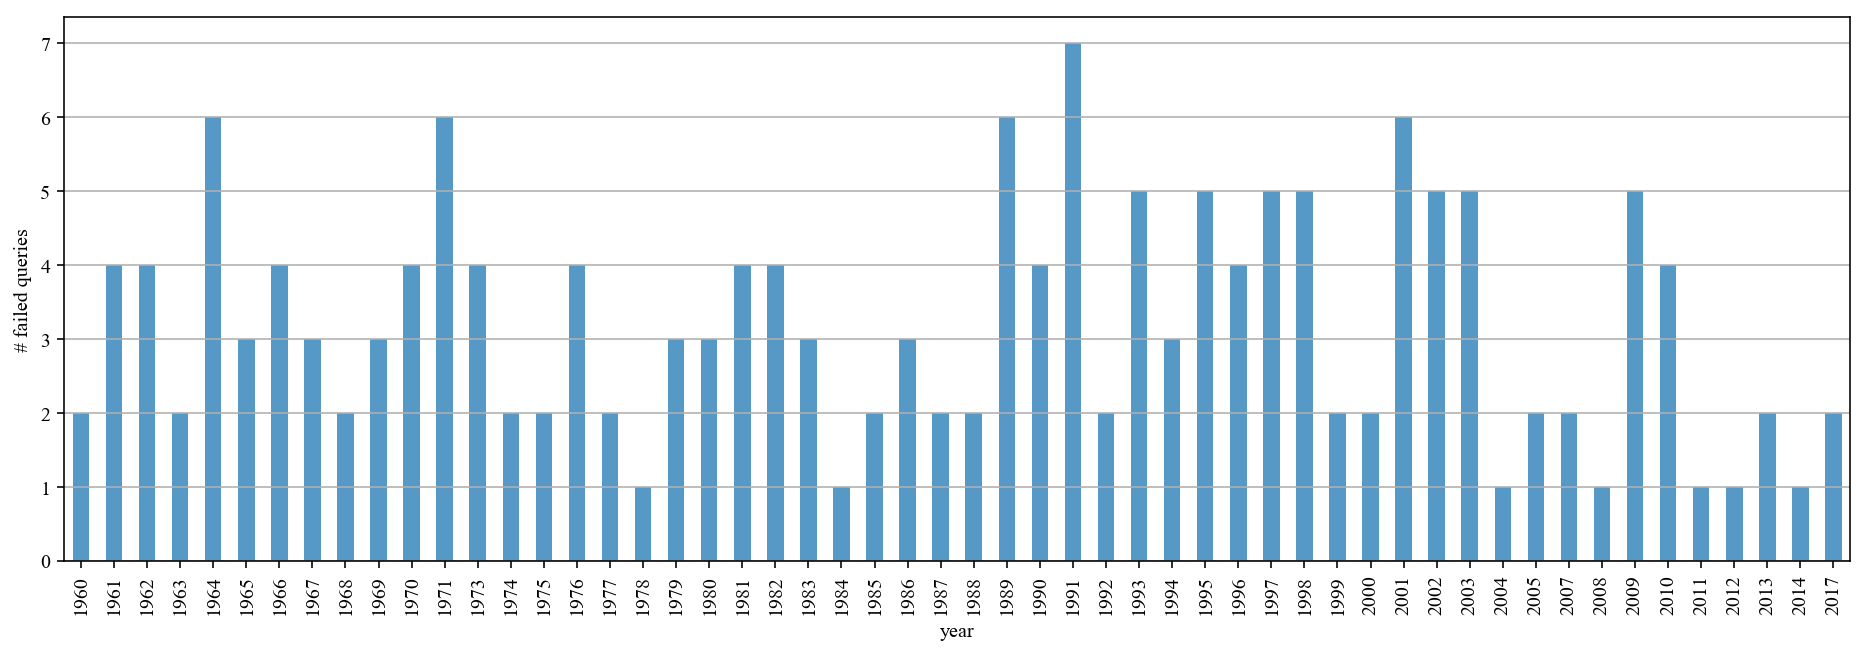

In [20]:
print('Unable to query {} songs for audio features'.format(len(failed)))

ax = failed.year\
           .value_counts()\
           .sort_index()\
           .plot.bar(figsize = (16,5), alpha=0.75)
ax.yaxis.grid(True)
ax.set(xlabel = 'year', ylabel = '# failed queries');

## Save Spotify data

In [24]:
df2.to_csv('../data/spotify.csv', index=False)

## Combine with Billboard and lyrics data
Finally, we combine all three data sources.

In [19]:
# df1 and df2 have different sizes because of unsuccessful queries
# therefore, we must merge on respective indices
billboard = pd.read_csv('../data/billboard-lyrics.csv')
df2 = pd.read_csv('../data/spotify.csv')
df1 = billboard.copy().drop(['index'], axis=1).reset_index()
df1['index'] = df1['index'].astype(float)
df_merge = pd.merge(df1, df2, how='left', left_on='index', right_on='billboard_df_index')

# billboard name and artist are copies of song and artist_base for verifying
# merge consistency and can be removed
column_mask = df_merge.columns.str.contains('billboard')
df_merge = df_merge.loc[:, ~column_mask]

# unnecessary to keep
df_merge = df_merge.drop(
    ['index', 'source', 'id', 'type', 'uri', 'spotify_artist',
     'spotify_song', 'spotify_album'], axis=1)

## Create derived features

In [20]:
# convert duration to more manageable units and drop original feature
df_merge['duration_min'] = df_merge['duration_ms'] / 1000 / 60
df_merge = df_merge.drop('duration_ms', axis=1)

# count number of words for each song
df_merge['num_words'] = df_merge['lyrics'].apply(
    lambda x: len(x.split()) if not isinstance(x, float) else np.nan)

# measure number of words per second for each song
df_merge['words_per_sec'] = df_merge['num_words'] /\
    (df_merge['duration_min'] * 60)

# count number of unique words for each song
df_merge['num_uniq_words'] = df_merge['lyrics'].apply(
    lambda x: pd.Series(
        x.split()).nunique() if not isinstance(x, float) else np.nan)

# convert years to decade for each song (but without dropping original feature)
df_merge['decade'] = df_merge['year'] // 10 * 10

# measure ratio of total words to unique words for each song
df_merge['uniq_ratio'] = df_merge['num_words'] / df_merge['num_uniq_words']
df_merge.tail()

,artist_all,artist_base,rank,song,year,artist_featured,song_clean,artist_clean,lyrics,acousticness,danceability,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,release_date,speechiness,tempo,time_signature,valence,duration_min,num_words,words_per_sec,num_uniq_words,decade,uniq_ratio
5796,camila cabello featuring young thug,camila cabello,96,havana,2017,young thug,havana,camila cabello,hey half of my heart is in havana ooh na na h...,0.18400,0.765,0.523,0.0,0.000036,2.0,0.1320,-4.333,1.0,94.0,2018-01-12,0.0300,104.988,4.0,0.394,3.621783,350.0,1.610625,102.0,2010,3.431373
5797,maroon 5 featuring sza,maroon 5,97,what lovers do,2017,sza,what lovers do,maroon 5,say say say hey hey now baby oh mama dont pla...,0.08050,0.792,0.612,0.0,0.000004,5.0,0.0852,-5.212,0.0,80.0,2017-11-03,0.0693,109.959,4.0,0.420,3.330817,366.0,1.831383,75.0,2010,4.880000
5798,blackbear,blackbear,98,do re mi,2017,NaN,do re mi,blackbear,do re mi fa so yeah yeah yeah oh do re mi fa ...,0.00419,0.742,0.599,1.0,0.000010,8.0,0.1260,-6.256,1.0,78.0,2017-04-21,0.0465,110.977,3.0,0.154,3.533783,382.0,1.801657,122.0,2010,3.131148
5799,xxxtentacion,xxxtentacion,99,look at me!,2017,NaN,look at me,xxxtentacion,ayy im like bitch who is your mans ayy cant k...,0.25900,0.763,0.726,1.0,0.000000,1.0,0.0976,-6.405,1.0,79.0,2017-02-20,0.2820,139.059,4.0,0.349,2.105767,337.0,2.667279,106.0,2010,3.179245
5800,keith urban featuring carrie underwood,keith urban,100,the fighter,2017,carrie underwood,the fighter,keith urban,i know he hurt you made you scared of love to...,0.03040,0.681,0.845,0.0,0.000000,11.0,0.1970,-5.147,0.0,70.0,2016-05-06,0.0525,132.023,4.0,0.761,3.067333,391.0,2.124538,87.0,2010,4.494253


## Final processing

In [23]:
# normalize artist name for beyonce
df_merge['artist_clean'] = df_merge['artist_clean'].replace('beyonce knowles', 'beyonce')

# remove duplicate songs
df_merge = df_merge.drop_duplicates(
    subset=['artist_clean', 'song_clean'], keep='first')

# strip whitespace at beginning and ends of artist columns
artist_cols = ['artist_base', 'artist_all', 'artist_featured', 'artist_clean']
df_merge[artist_cols] = df_merge[artist_cols].applymap(
    lambda x: x.strip() if not isinstance(x, float) else np.nan)
df_merge.shape

(5566, 30)

## Save combined data

In [24]:
df_merge.to_csv('../data/billboard-lyrics-spotify.csv', index=False)

In [32]:
df_merge['lyrics'].notnull().sum()

5516